In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

Import the Dataset

In [6]:
from google.colab import files
uploaded = files.upload()

Saving mldata.xlsx to mldata (1).xlsx


In [8]:
df = pd.read_excel('mldata (1).xlsx')
df

,day,occupancy,speed,flow,lanepts,%obs
0,2018-01-01,11.6,60.6,102591,1152,0.0
1,2018-01-02,11.4,61.8,104009,1152,0.0
2,2018-01-03,11.0,62.2,103958,1152,100.0
3,2018-01-04,11.2,62.4,105621,1152,100.0
4,2018-01-05,11.6,61.2,109556,1152,100.0
...,...,...,...,...,...,...
1822,2022-12-28,4.0,65.1,43909,1152,100.0
1823,2022-12-29,4.9,63.4,48448,1152,100.0
1824,2022-12-30,4.9,63.2,52664,1152,99.0
1825,2022-12-31,2.7,67.7,37332,1152,100.0


In [11]:
type(df['day'][0])

pandas._libs.tslibs.timestamps.Timestamp

Check for the correlation among the quantities flow, speed and occupancy

In [13]:
step = 1
pres = df[['speed','occupancy','flow']][0:-(step)].reset_index(drop=True)
future = df[['speed','occupancy','flow']][step:] \
    .reset_index(drop=True) \
    .add_suffix('_future')
val = pres.join(future)
val.corr()

,speed,occupancy,flow,speed_future,occupancy_future,flow_future
speed,1.000000,-0.746230,-0.046216,0.550783,-0.390883,-0.033725
occupancy,-0.746230,1.000000,0.556323,-0.321936,0.516569,0.432464
flow,-0.046216,0.556323,1.000000,0.058447,0.331841,0.769364
speed_future,0.550783,-0.321936,0.058447,1.000000,-0.746551,-0.047911
occupancy_future,-0.390883,0.516569,0.331841,-0.746551,1.000000,0.557517
flow_future,-0.033725,0.432464,0.769364,-0.047911,0.557517,1.000000


<Axes: >

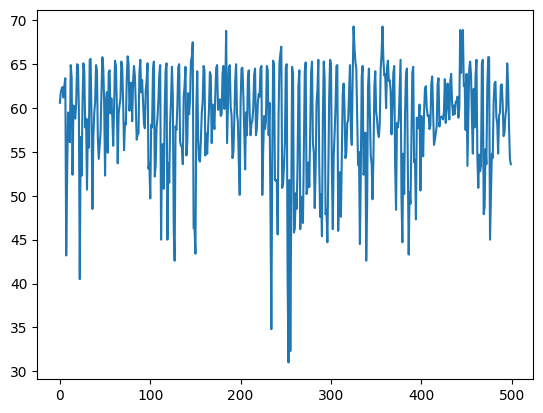

In [15]:
df['speed'][:500].plot()

<Axes: >

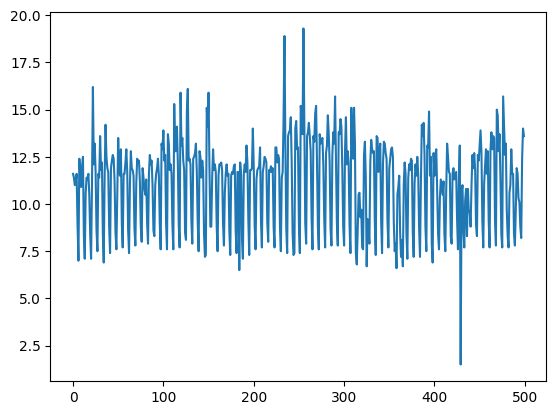

In [16]:
df['occupancy'][:500].plot()

<Axes: >

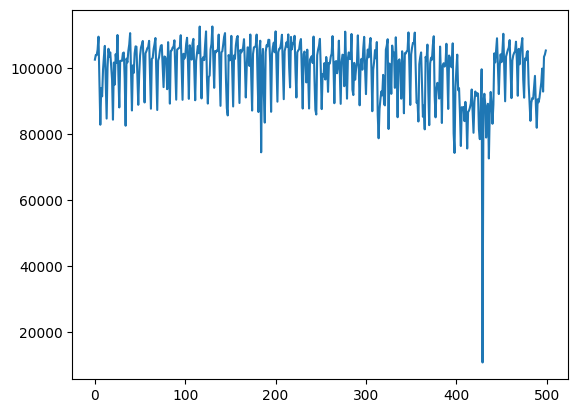

In [17]:
df['flow'][:500].plot()

A correlation of 0.7 to 0.9: is a strong positive correlation. This means that there is a strong positive relationship between the two variables being measured. In other words, as the value of one variable increases, the value of the other variable also tends to increase.

Set the x and y arrays

In [66]:
import numpy as np
#let inputs be speed and flow, and we will predict the occupancy
x=np.array(df[['speed','flow']])
y=np.array(df['occupancy'])

Perform the train test split:

In [187]:
#traintest data split:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3)
print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)


(1278, 2) (1278,)
(549, 2) (549,)


Scale the data using the minmaxscaler.
Also reshape the data inorder to give input to the model

In [188]:
#scaling data using minmaxscaler:
from sklearn.preprocessing import MinMaxScaler
scX=MinMaxScaler()
scY=MinMaxScaler()
xtrain=scX.fit_transform(xtrain)
xtest=scX.fit_transform(xtest)
ytrain=scY.fit_transform(ytrain.reshape(-1,1))
ytest=scY.fit_transform(ytest.reshape(-1,1))
xtrain=np.expand_dims(xtrain,-1)
ytrain=np.expand_dims(ytrain,-1)
print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)

(1278, 2, 1) (1278, 1, 1)
(549, 2) (549, 1)


Now build the model. I have use the simplernn model from tensorflow.

In [189]:
#building the model using functional api:
from tensorflow.keras.layers import Input, Dense, Dropout, SimpleRNN, LSTM
from tensorflow.keras.models import Model
model = tf.keras.Sequential()
model.add(SimpleRNN(16, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(16))
model.compile(loss='mse', optimizer='adam')
r = model.fit(xtrain, ytrain, epochs=100, validation_split=0.3)

Epoch 1/100
28/28 [==============================] - 1s 12ms/step - loss: 0.1843 - val_loss: 0.1335
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.1074 - val_loss: 0.0780
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0617 - val_loss: 0.0440
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0340 - val_loss: 0.0252
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0200 - val_loss: 0.0173
Epoch 6/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 7/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.0126
Epoch 8/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0107
Epoch 9/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0084 - val_loss: 0.0093
Epoch 10/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 11

As we plot the loss, it is quite lower than before.

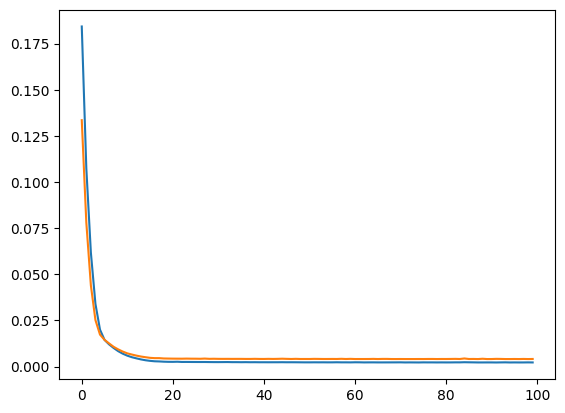

In [190]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

Now we perform predicition for ytrain data, and plot it again the original ytrain data.

In [191]:
pred1 = model.predict(xtrain)

40/40 [==============================] - 0s 3ms/step


In [192]:
ytrain=ytrain.reshape(1278,1)
pred1.shape

(1278, 16)

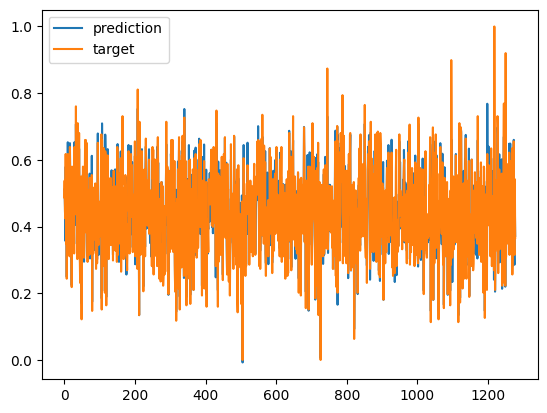

In [193]:
plt.plot(pred1[:,0], label='prediction')
plt.plot(ytrain, label='target')
plt.legend()

As we can see from above the predictions look quite good. Now we do the same for the xtest.

In [194]:
xtest.shape

(549, 2)

In [195]:
xtest=np.expand_dims(xtest,-1)
#
xtest.shape

(549, 2, 1)

18/18 [==============================] - 0s 2ms/step


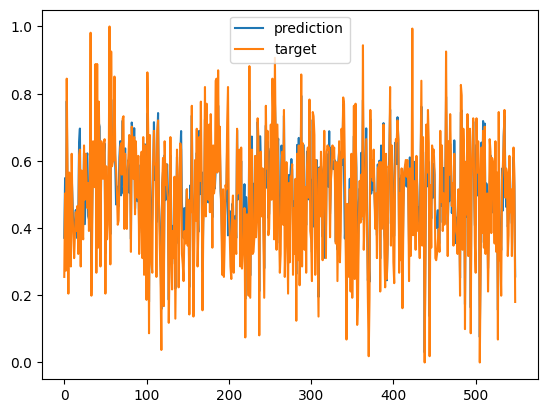

In [196]:
pred2 = model.predict(xtest)
plt.plot(pred2[:,0], label='prediction')
plt.plot(ytest, label='target')
plt.legend()

The prediction for xtest of same data is also good. Now let us confirm it with our metrics: RMSE and R2 score

In [197]:
model_RMSE = np.sqrt(np.mean((ytest - pred2[:,0]) ** 2))
print(model_RMSE)

0.22895137415931804


RMSE for test data is quite low, which is good sign.

In [198]:
model_RMSE = np.sqrt(np.mean((ytrain - pred1[:,0]) ** 2))
print(model_RMSE)

0.17438400167895116


RMSE for train data is also low, indicating that the model has learned the pattern.

R2 SCORE:

In [199]:
from sklearn.metrics import r2_score
r2_score(ytrain,pred1[:,0])

0.8327843829331593

R2 score for test data is 83.27% which is accurate enough.

In [200]:
from sklearn.metrics import r2_score
r2_score(ytest,pred2[:,0])

0.780160754068092

R2 score for test data is 78.01% which is quite a good metrics value.

UNSEEN DATA PREDICTION:

We have used the data for the time period of january 2018 to january 2023.
Let us try using our model to check the prediction for february month.

In [201]:
#forecast for unseen data:
from google.colab import files
uploaded = files.upload()

Saving forecast.xlsx to forecast.xlsx


In [217]:
df2=pd.read_excel('forecast.xlsx')
df2.head()

,day,flow,occ,speed,lanepts,%obs
0,2023-02-01,62450,7.9,48.5,1152,99.0
1,2023-02-02,63213,7.7,52.7,1152,99.7
2,2023-02-03,56993,7.0,63.3,1152,100.0
3,2023-02-04,52149,4.1,66.5,1152,100.0
4,2023-02-05,45884,3.5,65.9,1152,100.0


In [218]:
nx=np.array(df2[['speed','flow']])
ny=np.array(df2[['occ']])

In [219]:
#scaling:
nx = scX.fit_transform(nx)
ny = scY.fit_transform(ny)
nx.shape

(28, 2)

In [220]:
nx=np.expand_dims(nx,-1)
npred=model.predict(nx)

1/1 [==============================] - 0s 29ms/step


In [221]:
npred.shape

(28, 16)

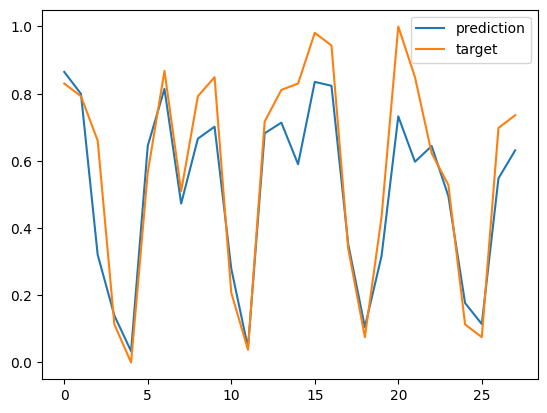

In [222]:
plt.plot(npred[:,0], label='prediction')
plt.plot(ny, label='target')
plt.legend()

As we plot the prediction against the actual values we see that our model has captured the data's pattern quite good and we can see that the error between prediction and target values is very less.

Even the r2 score is above 78%.

In [226]:
print('RMSE:',np.sqrt(np.mean((ny - npred[:,0]) ** 2)))
print('R2 Score:',r2_score(ny,npred[:,0]))

RMSE: 0.41700805972059085
R2 Score: 0.8353347996361974
